# Multi-Layer Perceptron

This TP introduces and trains a simple model of multi-layer perceptron (MLP).

In [27]:
import numpy as np
import matplotlib.pyplot as plt

## Dataset generation

We build a custom objective function in dimension 1, which we want the model to learn.

In [28]:
d = 1

# objective function
def f(x):
    return np.sin(6 * np.pi * np.abs(x) ** 1.5) + x ** 3

# data
n = 256
X = np.linspace(-1, 1, n)[:, None]
y = f(X)

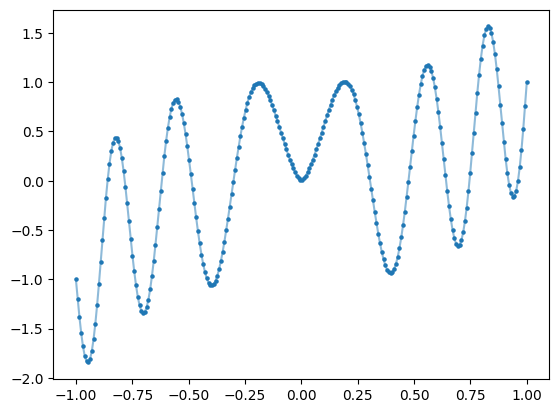

In [29]:
plt.scatter(X, y, s=5)
plt.plot(X, y, alpha=0.5)
plt.show()

We add a column of ones to $X$ to easily handle the bias in our models.

In [30]:
X_bias = np.concatenate([X, np.ones((n, 1))], axis=1)

## Linear regression

We first try to learn $f$ with a linear model $x\mapsto w_1 x + w_2$, where $w\in \R^2$ is the vector of parameters. We take the quadratic loss and look for
$$\mathrm{argmin}_{w\in \mathbb{R}^2} \frac{1}{n} \| X_\text{bias} w - y\|^2.$$

Implement a gradient descent on the loss function and display the result. Does it reach a minimizer of the loss?

In [31]:
def loss_gradient(w, X_bias, y):
    return X_bias.T @ (X_bias @ w - y[:, 0]) * 2 / n

def loss(w, X_bias, y):
    residual = X_bias @ w - y[:, 0]
    return np.sum(residual ** 2) / n

In [32]:
n_iter = 100
learning_rate = 0.1
w0 = np.random.randn(2)
w = w0.copy()
w_list = [w.copy()]

for i in range(n_iter):
    w -= learning_rate * loss_gradient(w, X_bias, y)
    w_list.append(w.copy())

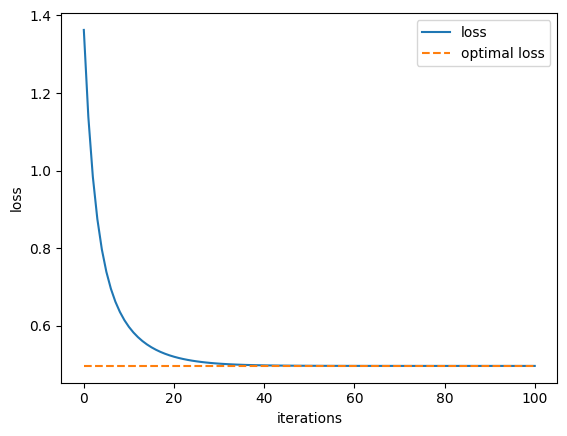

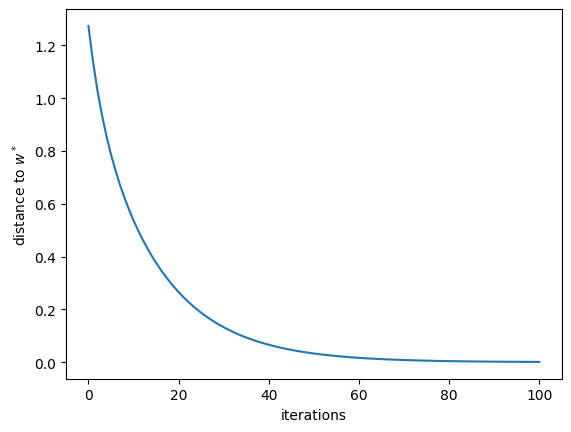

In [33]:
w_star = np.linalg.inv(X_bias.T @ X_bias) @ X_bias.T @ y[:, 0]

plt.plot(np.array([loss(w, X_bias, y) for w in w_list]))
plt.plot(np.array([loss(w_star, X_bias, y)] * len(w_list)), '--')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend(['loss', 'optimal loss'])
plt.show()

plt.plot(np.array([np.linalg.norm(w - w_star) for w in w_list]))
plt.ylabel(r'distance to $w^*$')
plt.xlabel('iterations')
plt.show()

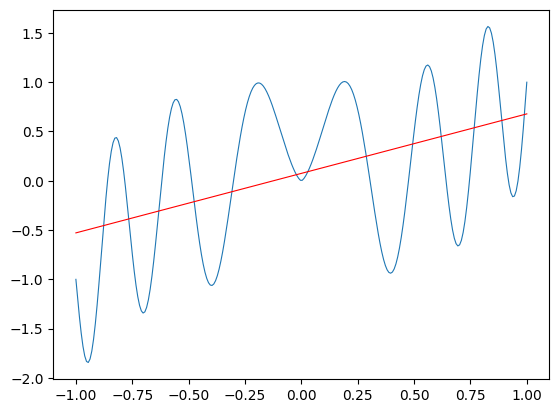

In [34]:
plt.plot(X, y, linewidth=0.8)
plt.plot(X, X_bias @ w, 'r', linewidth=0.8)
plt.show()

## Multi-layer perceptron

Let us now consider a one-hidden-layer MLP of parameters $W\in \mathbb{R}^{q\times (d+1)}$ and $v\in \mathbb{R}^q$:
$$f_{W, v}(x) := \sum_{k = 1}^q v_k \phi(\langle w_k, x_\text{bias}\rangle)$$
where $q$ is the number of neurons, $w_k$ is the $k$-th row of the matrix $W$ and $\phi\colon \mathbb{R}\to \mathbb{R}$ is a fixed non-linear activation function.
Recall that $x_\text{bias} := (x^\top, 1)^\top$.

Let us use a sigmoid as activation function.

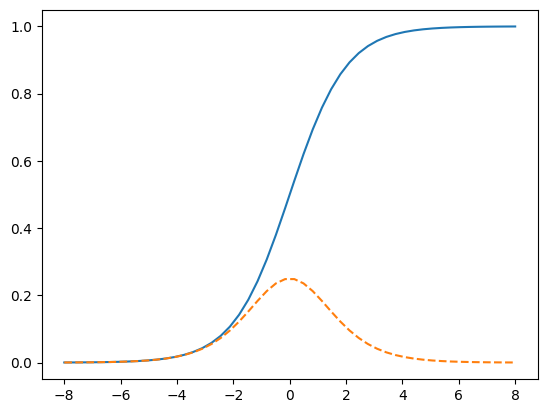

In [35]:
def phi(x):
    return 1 / (1 + np.exp(-x))

def phi_grad(x):
    return np.exp(-x) / (1 + np.exp(-x)) ** 2

t = np.linspace(-8, 8)
plt.plot(t, phi(t))
plt.plot(t, phi_grad(t), '--')
plt.show()

We take the loss
$$\mathcal{E}(W, v) := \frac1n \sum_{i=1}^n (f_{W, v}(x_i) - y_i)^2.$$

### Gradient descent

To code it efficiently, it is more practical to write $f$ in its matrix form:
$$f_{W, v}(X) = \phi(X_\text{bias} W^\top) v,$$
where $\phi$ is applied entry-wise.
Compute the gradient of $\mathcal{E}$ with respect to $v$ and $W$.

As is usual, we implement `W` as $W^\top$. Then, the gradient is also transposed: be careful with the dimensions!

In [36]:
def f(W, v):
    return phi(X_bias @ W) @ v[:, None]

def loss(W, v):
    residual = phi(X_bias @ W) @ v - y[:, 0]
    return np.sum(residual ** 2) / n

def loss_grad_v(W, v):
    B = phi(X_bias @ W)
    return B.T @ (B @ v - y[:, 0]) * 2 / n

def loss_grad_W(W, v):
    R = phi(X_bias @ W) @ v - y[:, 0]
    return X_bias.T @ (phi_grad(X_bias @ W) * np.outer(R, v)) * 2 / n

Initialize the parameters.

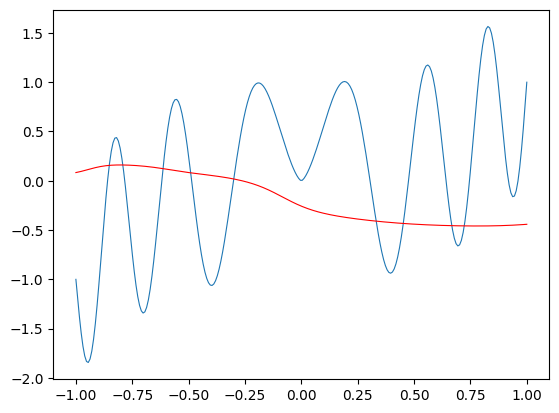

In [37]:
q = 20
W0 = np.random.randn(d + 1, q) * 10
v0 = np.random.randn(q) / 10

# plot init
plt.plot(X, y, linewidth=0.8)
plt.plot(X, f(W0, v0), 'r', linewidth=0.8)
plt.show()

Perform a gradient descent on the parameters, with a different learning rate for $W$ and $v$. Display the evolution of the loss.

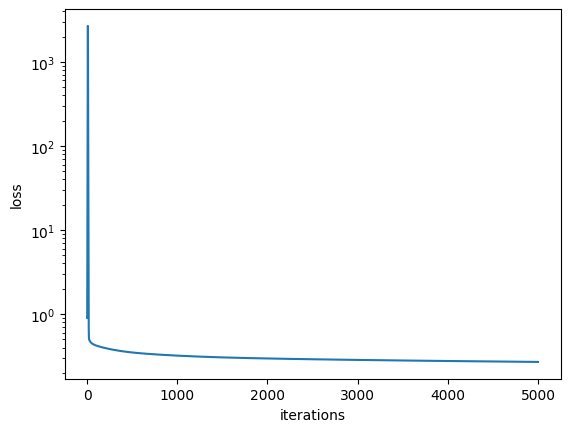

In [38]:
n_iter = 5000
learning_rate_W, learning_rate_v = 0.15, 0.18

(W, v) = (W0.copy(), v0.copy())
param_list = [(W.copy(), v.copy())]

for i in range(n_iter):
    W -= learning_rate_W * loss_grad_W(W, v)
    v -= learning_rate_v * loss_grad_v(W, v)
    param_list.append((W.copy(), v.copy()))

plt.semilogy(np.array([loss(W, v) for W, v in param_list]))
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

Plot the obtained predictor.

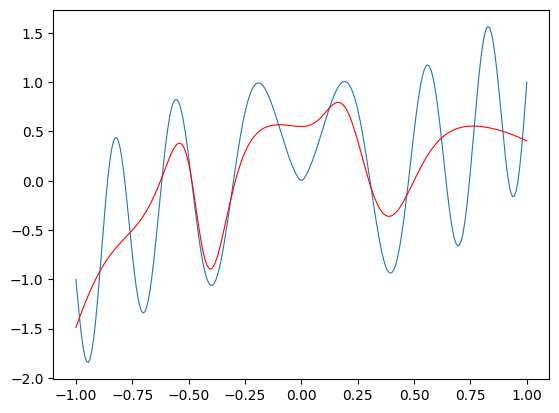

In [39]:
plt.plot(X, y, linewidth=0.8)
plt.plot(X, f(W, v), 'r', linewidth=0.8)
plt.show()

### Optimizing with a solver

You probably noticed that it is difficult to tune the learning rates. Instead of gradient descent, let us use a solver from scipy.

First, we have to rewrite the loss and its gradient as functions of only one array.

In [40]:
def loss_for_solver(params):
    q = len(params) // (d + 2)
    params = params.reshape(d + 2, q)
    W = params[:d + 1]
    v = params[d + 1:][0]
    return loss(W, v)

def grad_loss_for_solver(params):
    q = len(params) // (d + 2)
    params = params.reshape(d + 2, q)
    W = params[:d + 1]
    v = params[d + 1:][0]
    return np.concatenate((loss_grad_W(W, v).flatten(), loss_grad_v(W, v).flatten()), axis=0)

from scipy.optimize import minimize
result = minimize(loss_for_solver, np.concatenate((W0.flatten(), v0.flatten()), axis=0), method='L-BFGS-B', jac=grad_loss_for_solver)
params = result.x.reshape(d + 2, q)
W = params[:d + 1]
v = params[d + 1:][0]

Plot the obtained predictor.

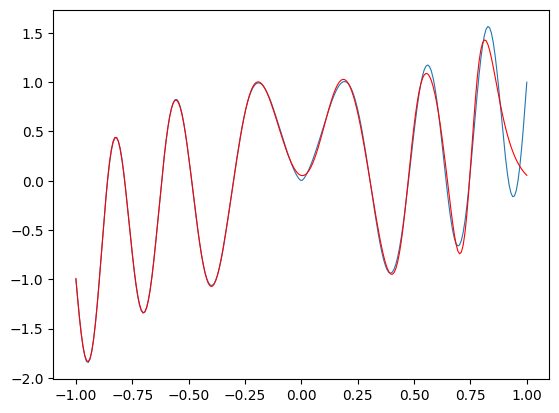

In [41]:
plt.plot(X, y, linewidth=0.8)
plt.plot(X, f(W, v), 'r', linewidth=0.8)
plt.show()

### Expressive power analysis

Using the solver, study the influence of the hidden layer width $q$ on the learned predictor. Although the solver does not always find the best predictor, the results give a proxy for the expressive power of MLPs with one hidden layer depending on $q$.

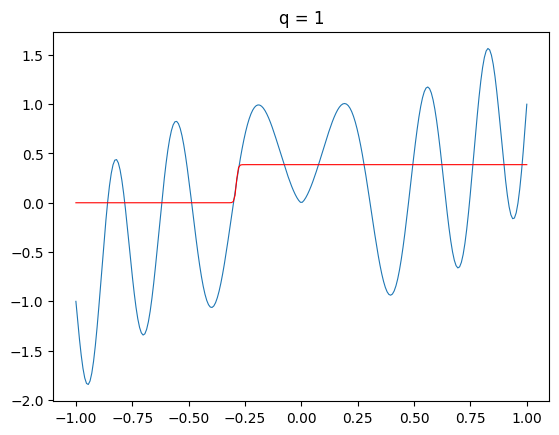

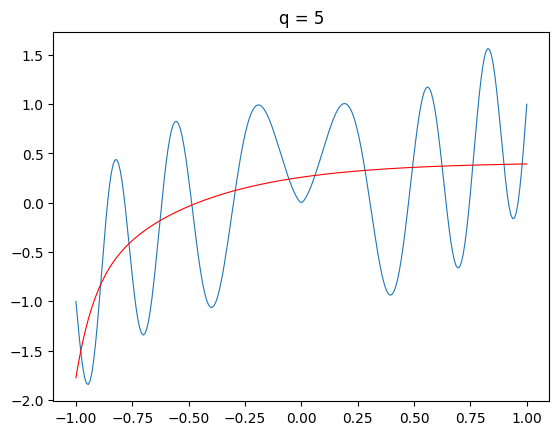

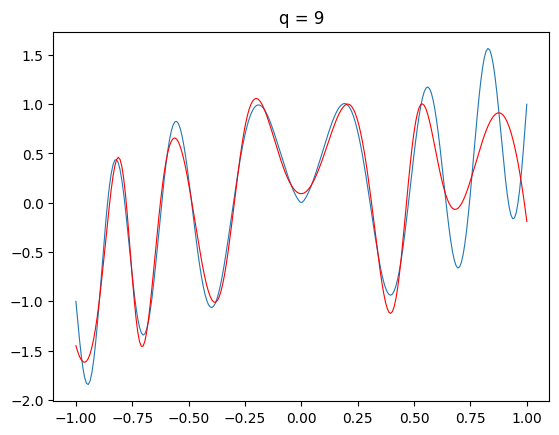

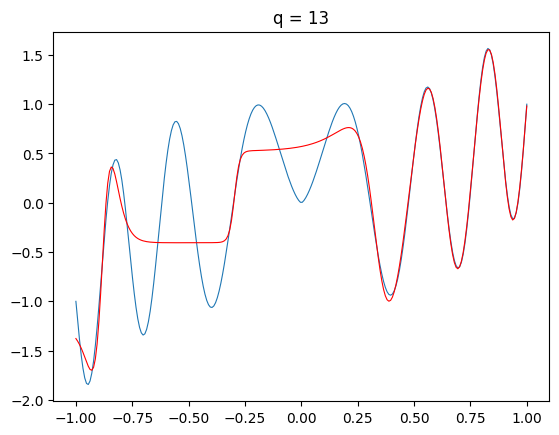

In [42]:
mlp_widths = np.arange(1, 15, 4)

for q in mlp_widths:
    W0 = np.random.randn(d + 1, q) * 10
    v0 = np.random.randn(q) / 10

    result = minimize(loss_for_solver, np.concatenate((W0.flatten(), v0.flatten()), axis=0), method='L-BFGS-B', jac=grad_loss_for_solver)
    params = result.x.reshape(d + 2, q)
    W = params[:d + 1]
    v = params[d + 1:][0]

    plt.plot(X, y, linewidth=0.8)
    plt.plot(X, f(W, v), 'r', linewidth=0.8)
    plt.title(f'q = {q}')
    plt.show()

### Lazy regime

We can also investigate the so-called "lazy regime", where $W$ is fixed from initialization, and only $v$ is updated. The model is then easier to train once the first layer is fixed, but less expressive.

Implement gradient descent in the lazy regime. Try with an increasing number of hidden neurons.

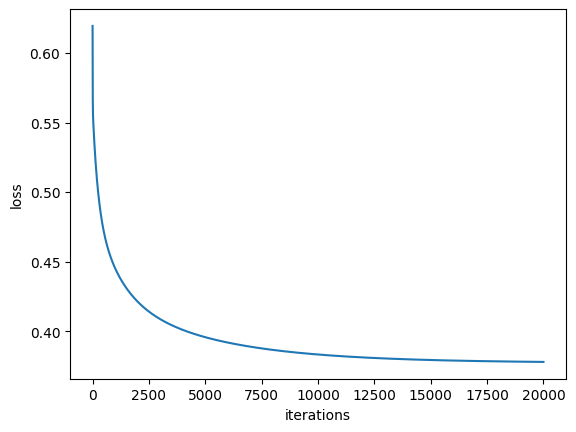

In [43]:
n_iter = 20000
learning_rate_W, learning_rate_v = 0., 0.07

q = 30
# W0 = np.random.randn(d + 1, q) * 10
# v0 = np.random.randn(q) / 10

(W, v) = (W0.copy(), v0.copy())
param_list = [(W.copy(), v.copy())]

for i in range(n_iter):
    W -= learning_rate_W * loss_grad_W(W, v)
    v -= learning_rate_v * loss_grad_v(W, v)
    param_list.append((W.copy(), v.copy()))

plt.plot(np.array([loss(W, v) for W, v in param_list]))
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

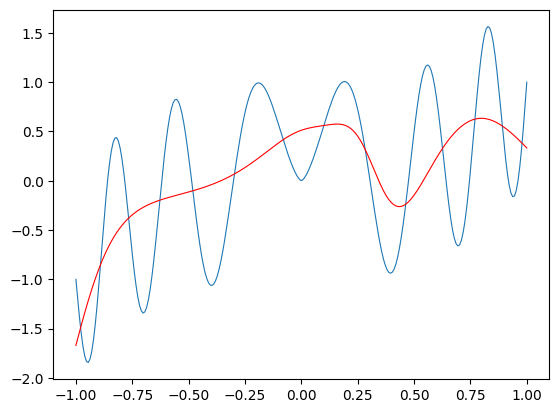

In [44]:
plt.plot(X, y, linewidth=0.8)
plt.plot(X, f(W, v), 'r', linewidth=0.8)
plt.show()